In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats.mstats import winsorize
import joblib
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
%matplotlib inline

2024-07-07 11:22:19.557231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 11:22:20.408481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set seed for reproducability
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)

# Description of the dataset
This dataset is taken from UC Irvine's open source Machine Learning Repository.

1.date: Date in format dd/mm/yyyy
2.time: time in format hh:mm:ss
3.global_active_power: household global minute-averaged active power (in kilowatt)
4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5.voltage: minute-averaged voltage (in volt)
6.global_intensity: household global minute-averaged current intensity (in ampere)
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

Note: (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

# Data Preprocessing

In [3]:
raw_data = pd.read_csv('household_power_consumption.txt', delimiter=';', 
                       na_values=['?', 'nan'], low_memory=False)

In [4]:
raw_data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
raw_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [6]:
# Combining datetime column into one
raw_data['Datetime'] = pd.to_datetime(raw_data['Date'], dayfirst=True) + pd.to_timedelta(raw_data['Time'])
raw_data.set_index('Datetime', inplace=True)
raw_data.drop(['Date', 'Time'], axis=1, inplace=True)

In [7]:
raw_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
raw_data.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [9]:
# As this is time series data, it makes sense for us to use the ffill method to fill in the null values
raw_data.fillna(method='ffill', inplace=True)

In [10]:
raw_data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [11]:
# Now that we have dealt with the missing values, we calculate the extra column representing the remaining power consumed
# We calculate this according to the formula mentioned.
raw_data['rem_consumption'] = (raw_data['Global_active_power'] * 1000 / 60 - 
                               raw_data['Sub_metering_1'] - raw_data['Sub_metering_2'] - raw_data['Sub_metering_3'])

In [12]:
# Changing the freqeuncy of the data to hourly data because electricty consumption will most likely not change drastically within the same hour.
raw_data.index.freq = 'min'
hourly_data = raw_data.resample(rule='1H').mean()

In [13]:
hourly_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,1.086200,0.123326,240.841505,4.604360,1.110951,1.287914,6.416515,9.287961
std,0.894942,0.067221,2.999127,3.746337,3.518498,4.168720,7.344718,8.244255
min,0.124000,0.000000,225.834500,0.503333,0.000000,0.000000,0.000000,1.379444
25%,0.341267,0.077667,239.197167,1.510000,0.000000,0.000000,0.650000,4.351667
50%,0.799533,0.106767,240.984500,3.406667,0.000000,0.333333,1.650000,5.742222
75%,1.574967,0.149367,242.691833,6.583333,0.000000,0.650000,14.083333,11.118889
max,6.560533,0.774333,251.902000,28.383333,48.366667,46.433333,21.550000,64.837222


In [14]:
# # Columns to winsorize
# columns_to_winsorize = hourly_data.columns

# # Apply winsorization using scipy.stats.mstats.winsorize
# for col in columns_to_winsorize:
#     hourly_data[col] = winsorize(hourly_data[col], limits=(0.02, 0.02))

In [15]:
hourly_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,1.074366,0.122299,240.848156,4.553177,0.989563,1.146777,6.410785,9.178753
std,0.853158,0.061789,2.856950,3.560569,2.851488,3.299405,7.334415,7.776611
min,0.182467,0.044867,233.796333,0.860000,0.000000,0.000000,0.000000,2.149444
25%,0.341267,0.077667,239.197167,1.510000,0.000000,0.000000,0.650000,4.351667
50%,0.799533,0.106767,240.984500,3.406667,0.000000,0.333333,1.650000,5.742222
75%,1.574967,0.149367,242.691833,6.583333,0.000000,0.650000,14.083333,11.118889
max,3.471100,0.321133,246.958667,14.676667,12.533333,18.800000,19.250000,34.904444


# Exploratory Data Analysis

In [16]:
# Since it is time series data, an ETS decompostion of the data would give a much better understanding of the trend and seasonality.
# Perform ETS decomposition
def ets_decomposition_plot(time_series):
    result = seasonal_decompose(time_series, model='additive')
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6))

    result.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed')
    ax1.set_xlabel('')

    result.trend.plot(ax=ax2)
    ax2.set_ylabel('Trend')
    ax2.set_xlabel('')

    result.seasonal.plot(ax=ax3)
    ax3.set_ylabel('Seasonal')
    ax3.set_xlabel('')

    result.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual')
    ax4.set_xlabel('Index')

    plt.show()

Global_active_power


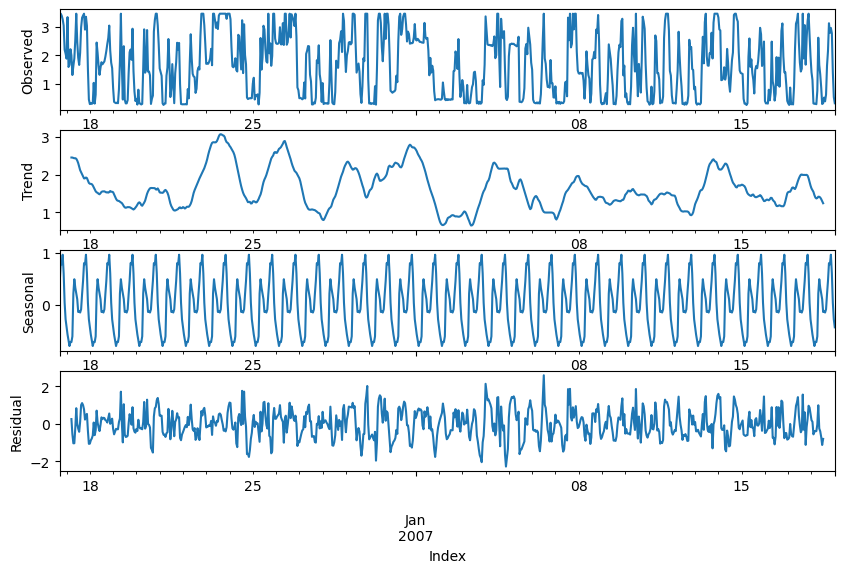

Global_reactive_power


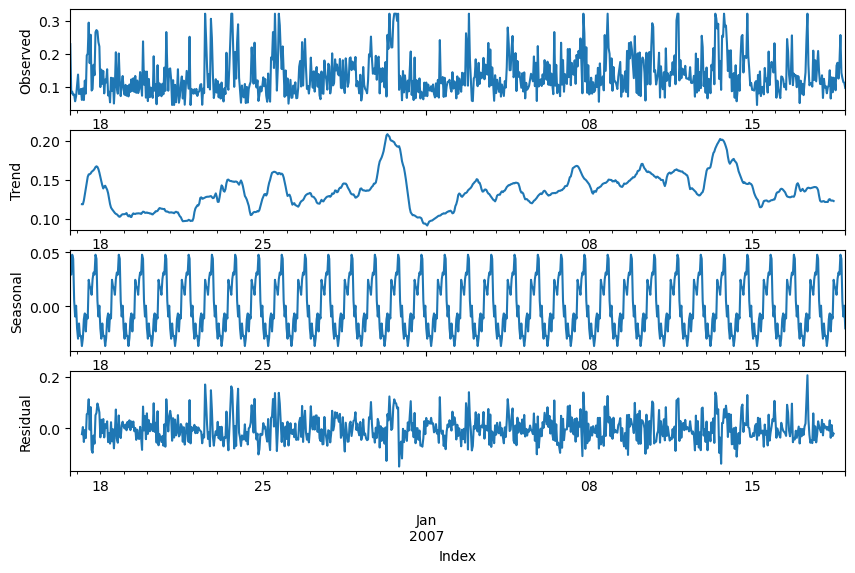

Voltage


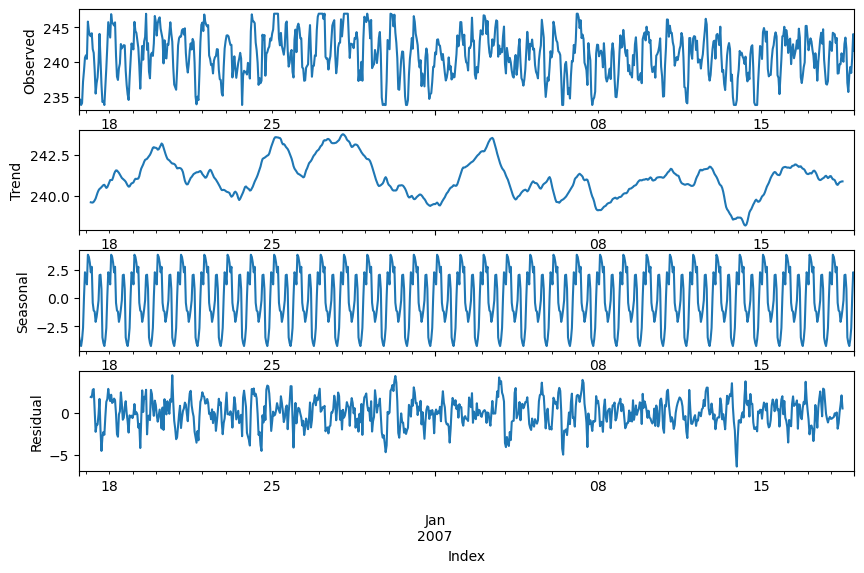

Global_intensity


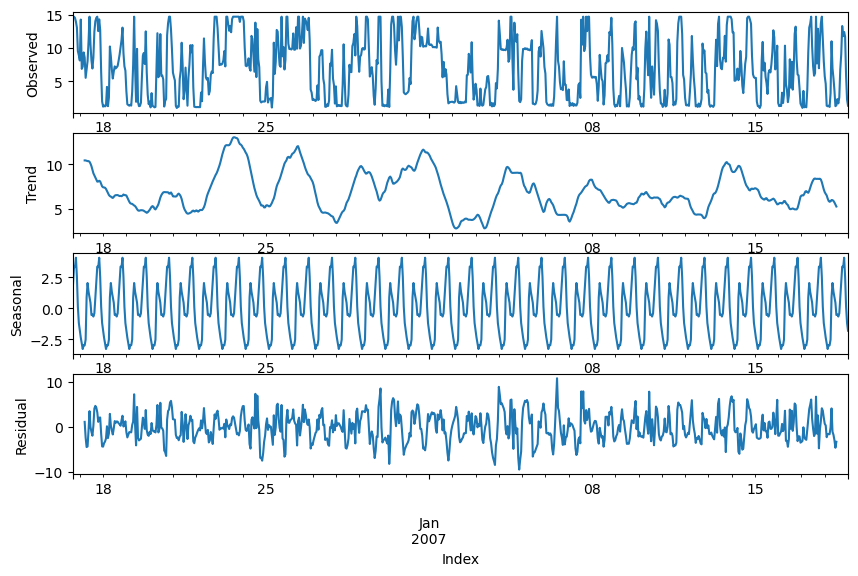

Sub_metering_1


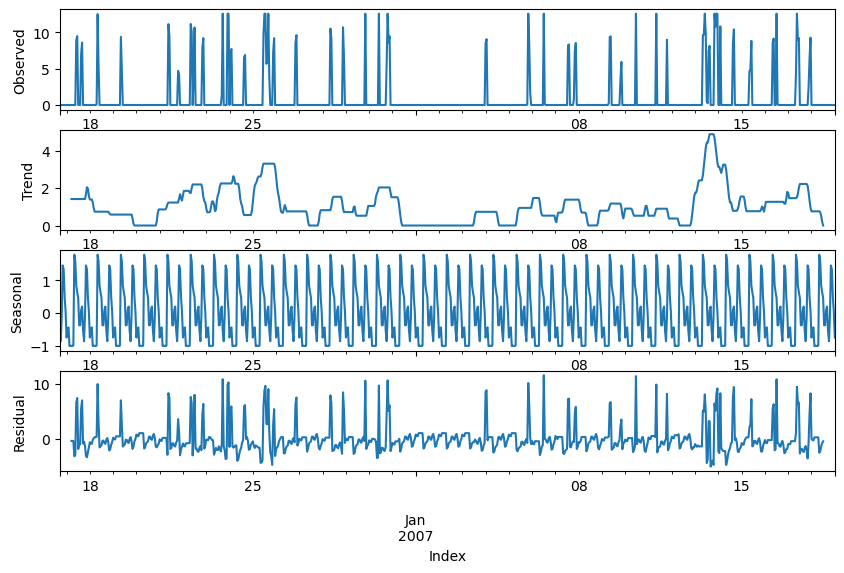

Sub_metering_2


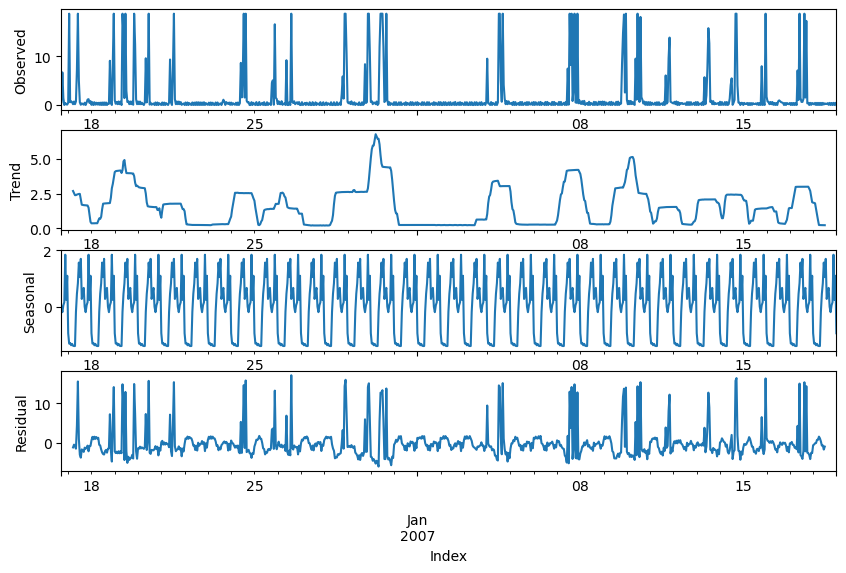

Sub_metering_3


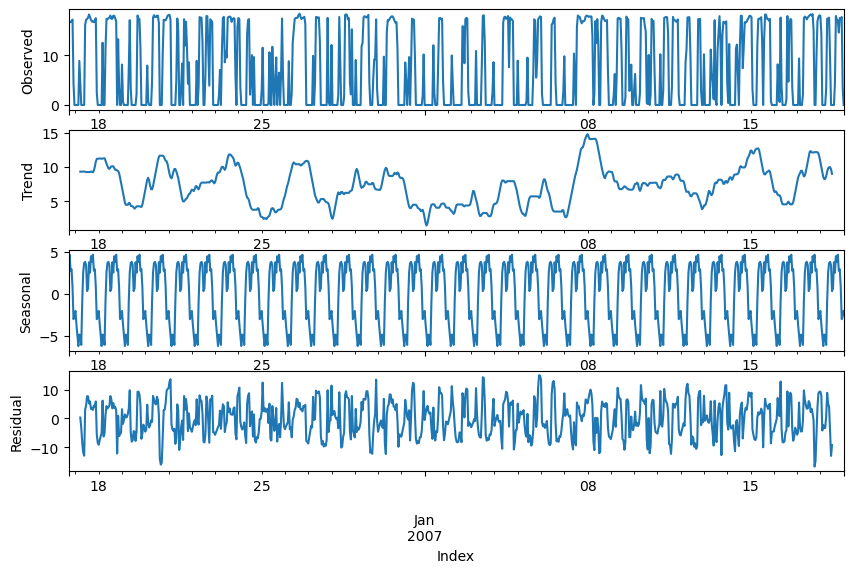

rem_consumption


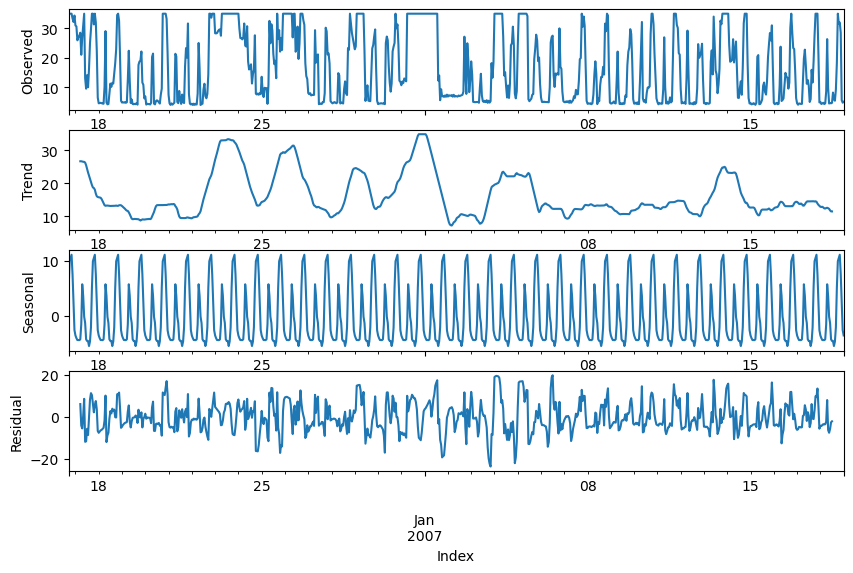

In [17]:
for col in hourly_data.columns:
    print(col)
    ets_decomposition_plot(hourly_data[:800][col])

Remark: There is a clear seasonal component and an irregular trend in the data(observed for all columns). Exogenous features might be useful for us in making forecasts.

### Autocorrelation analysis
We plot the correlation and autocorrelation plots.

ACF plot - Helps us identify if a particular time series column is uselful for forecasting values in the same time series column.
How is this done?
After the first lag, if the ACF plot shows positive autocorrelation, we infer that the time series is auto correlated.

PACF plot - If ACF shows autocorrelation, we use the PACF plot to identify how many of its previous values might be helpful for predicting the future values.
How is this done?
If after lag k there is a sharp drop in the value of PACF, we infer that to predict a future value, consider the previous k lags in the time series

Global_active_power


<Figure size 600x400 with 0 Axes>

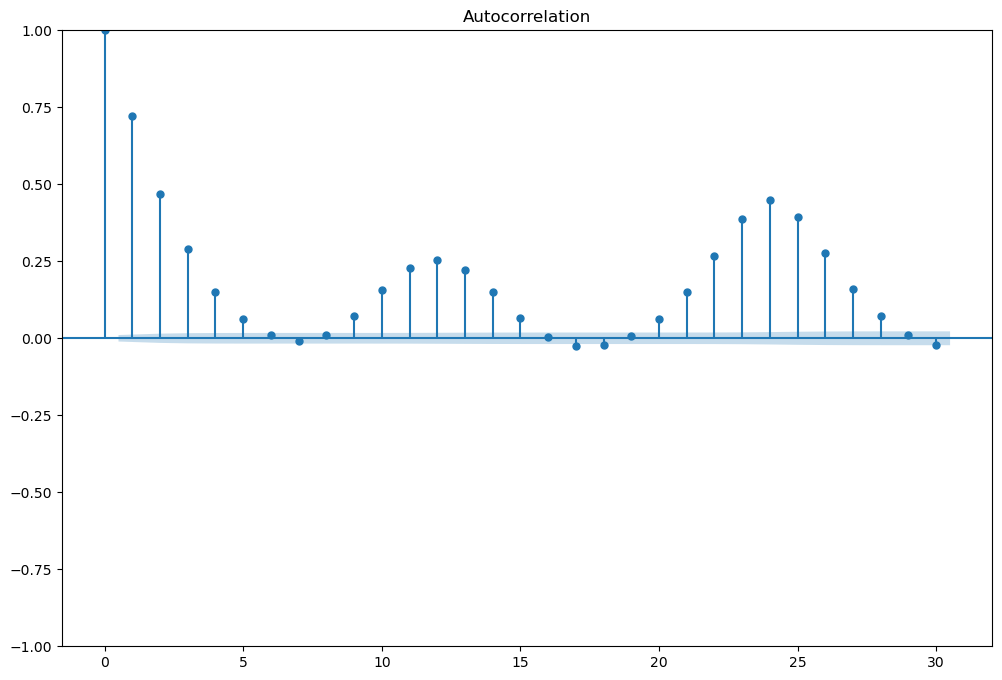

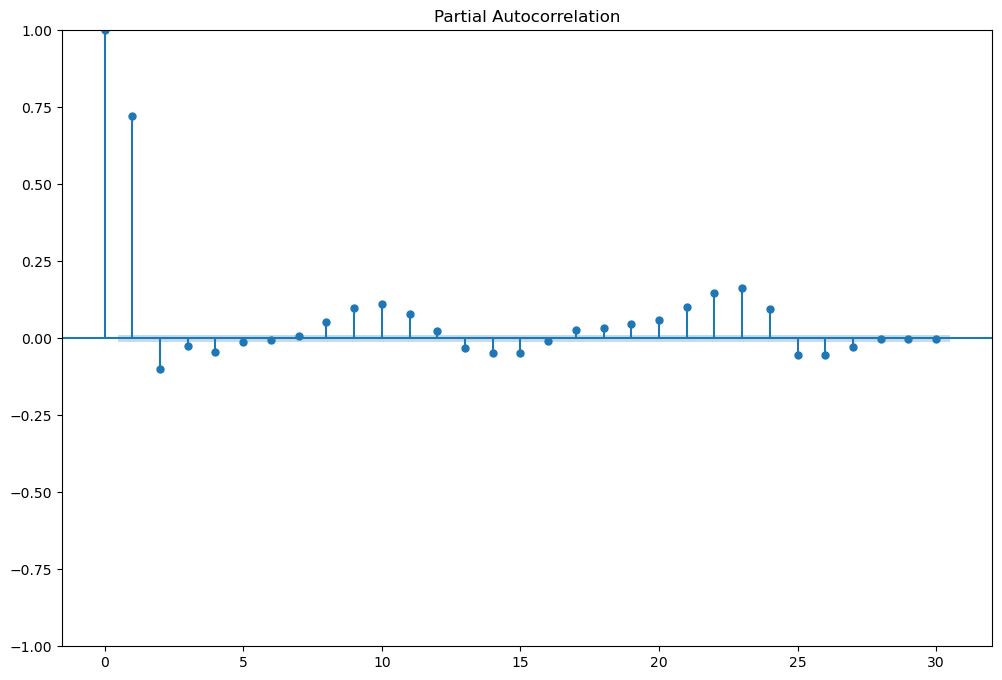

Global_reactive_power


<Figure size 600x400 with 0 Axes>

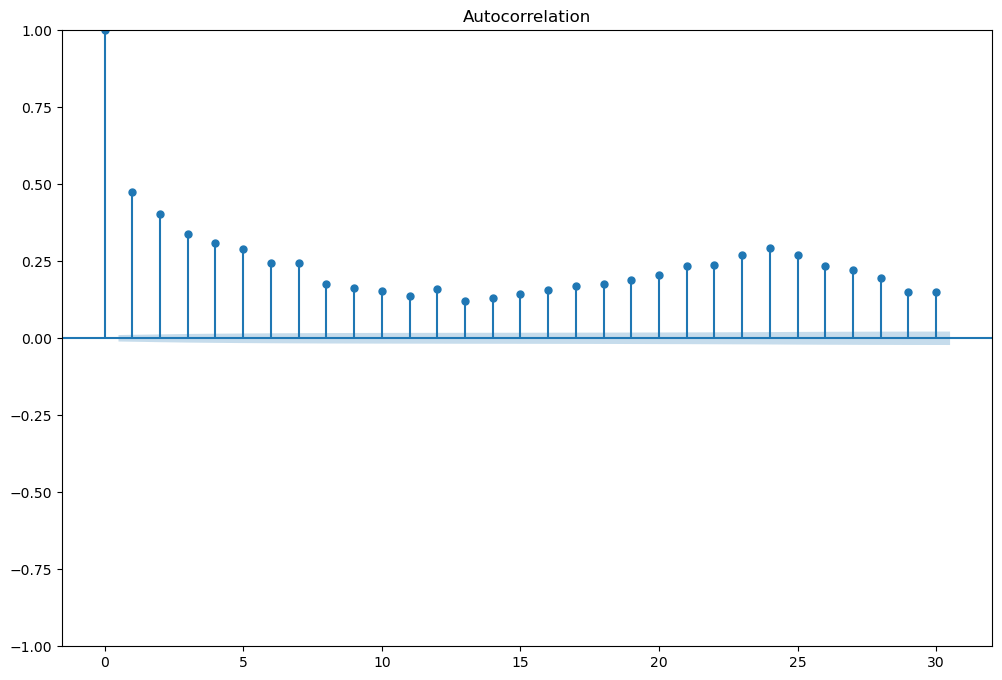

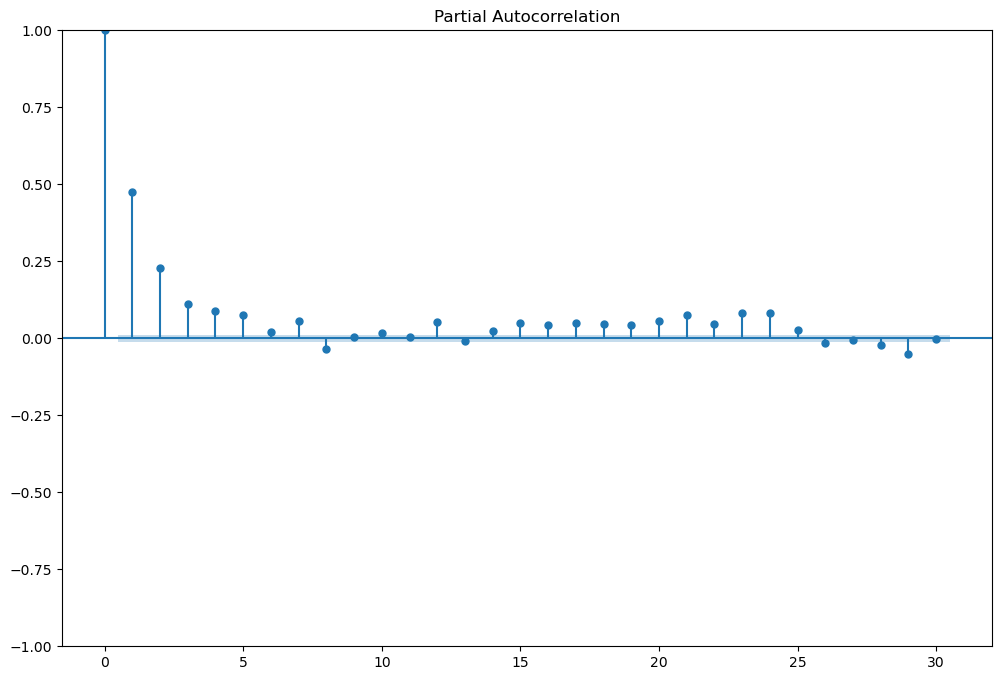

Voltage


<Figure size 600x400 with 0 Axes>

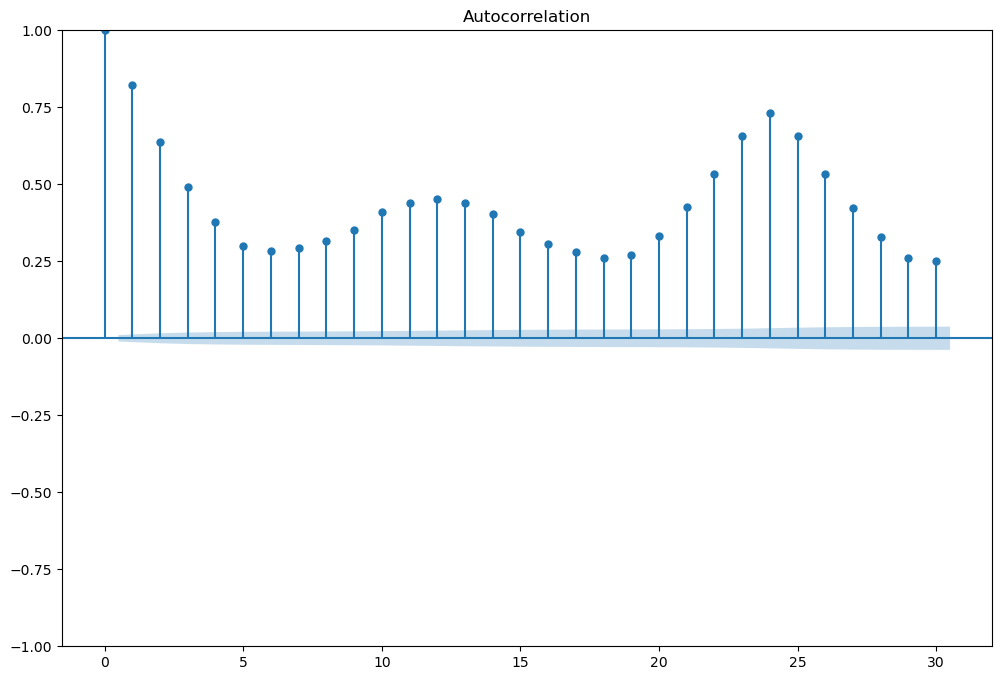

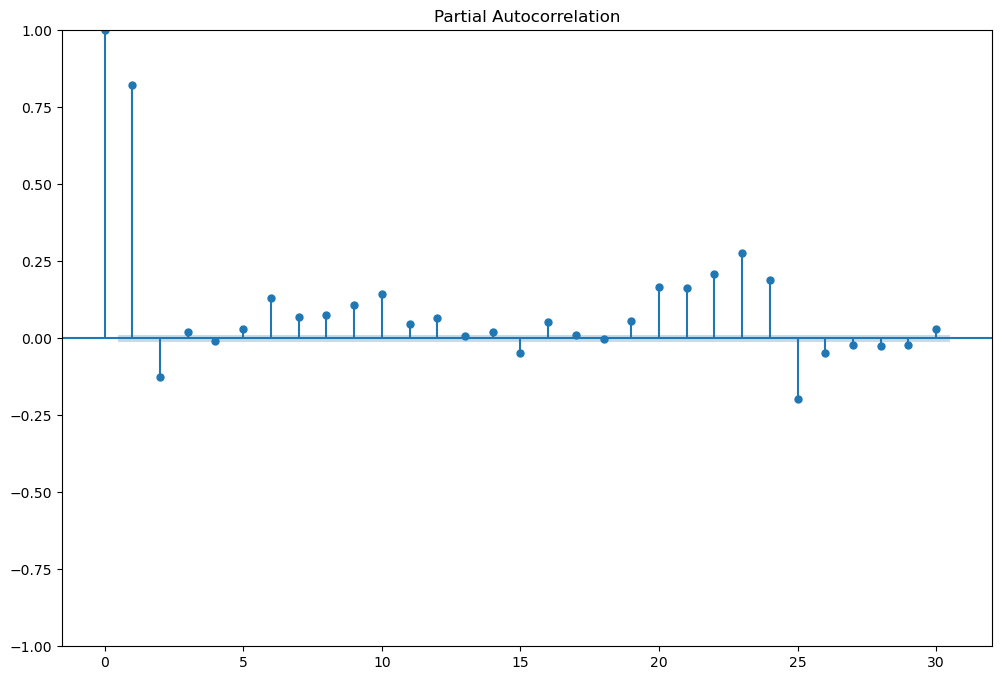

Global_intensity


<Figure size 600x400 with 0 Axes>

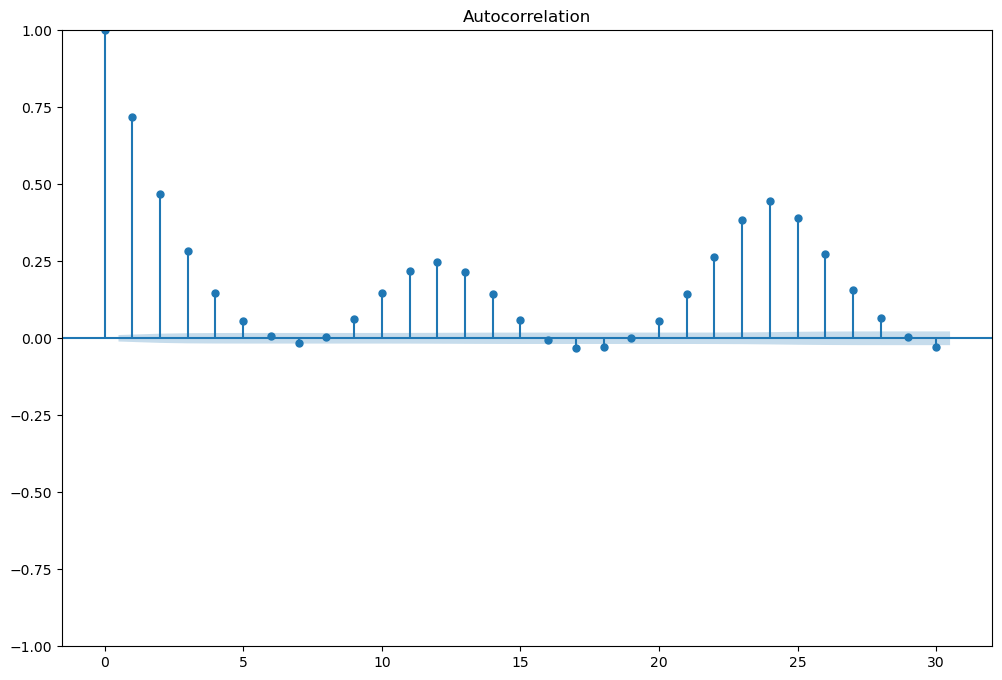

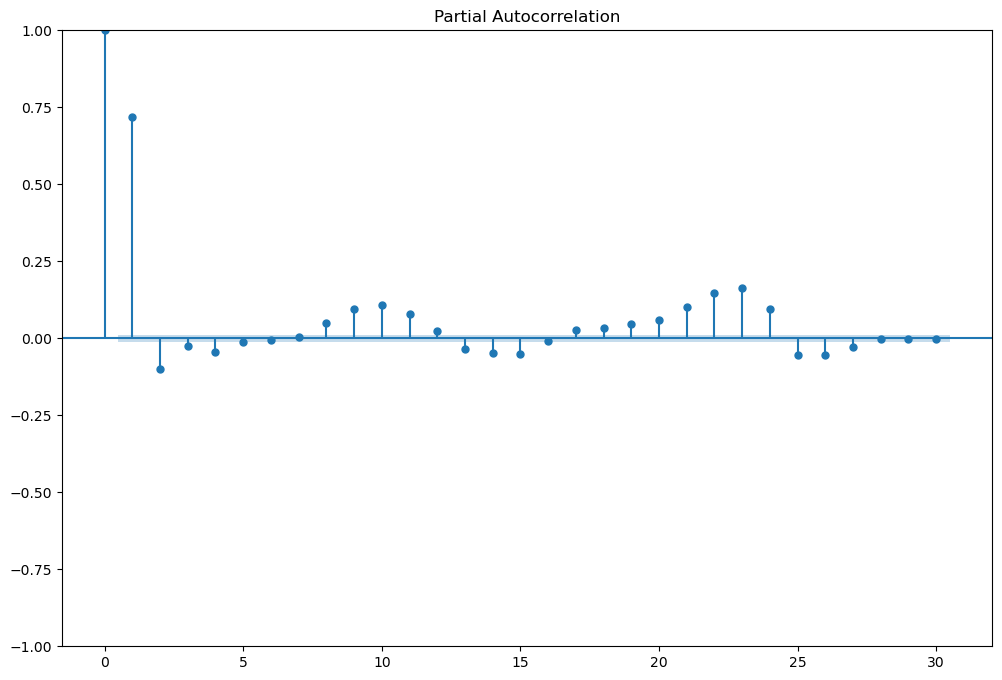

Sub_metering_1


<Figure size 600x400 with 0 Axes>

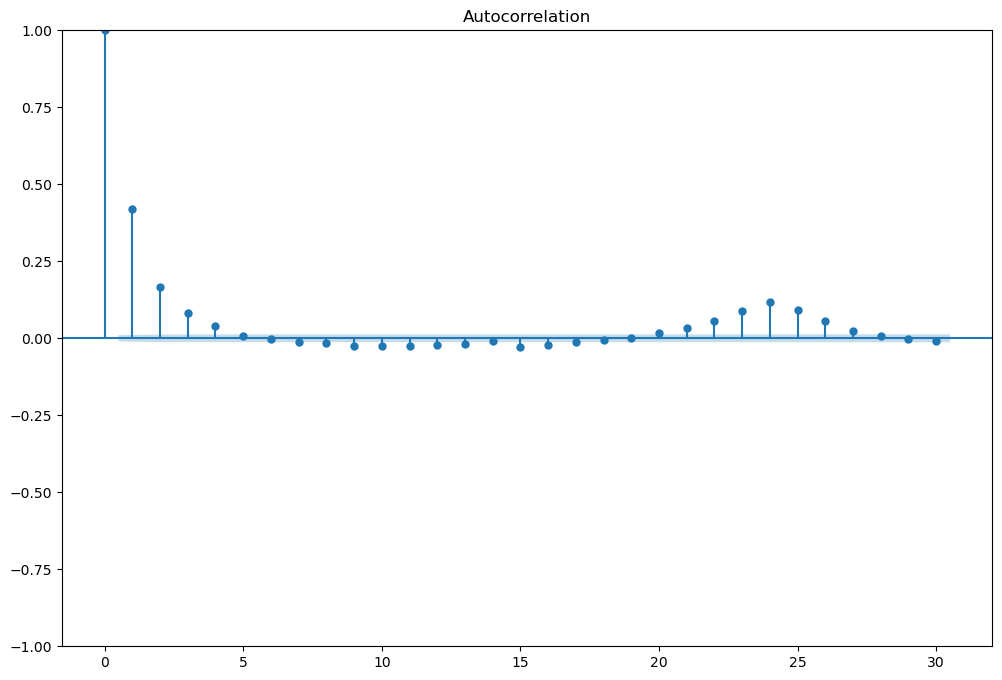

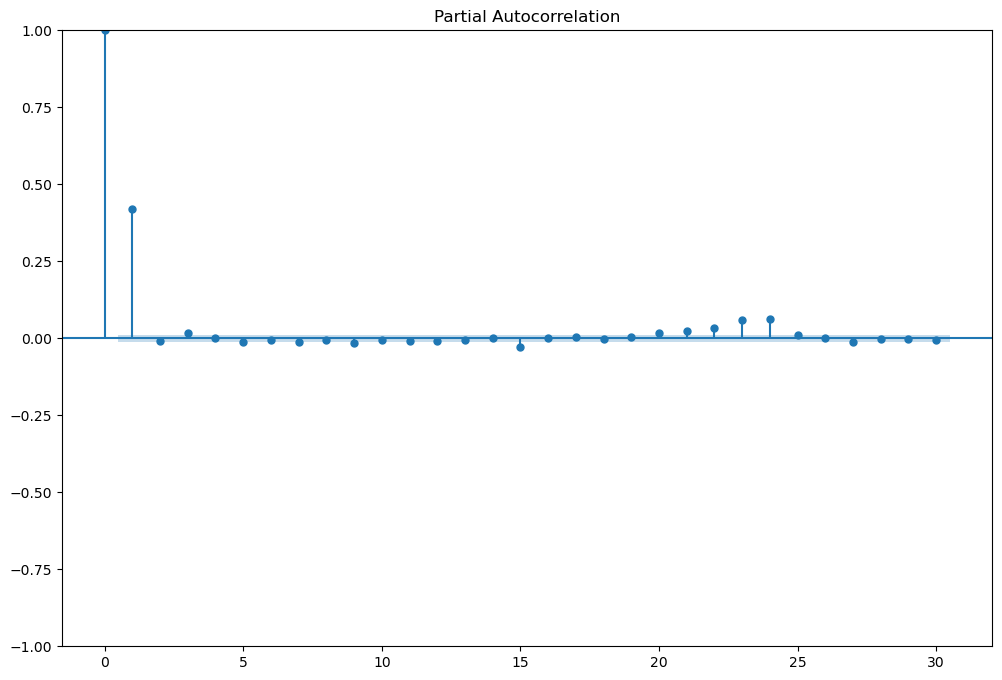

Sub_metering_2


<Figure size 600x400 with 0 Axes>

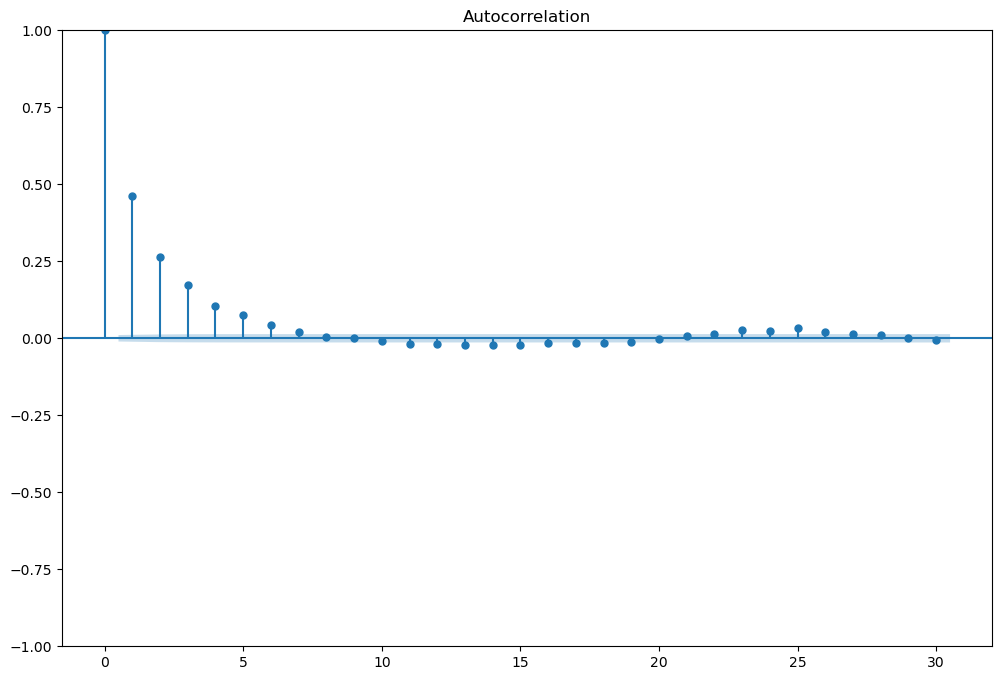

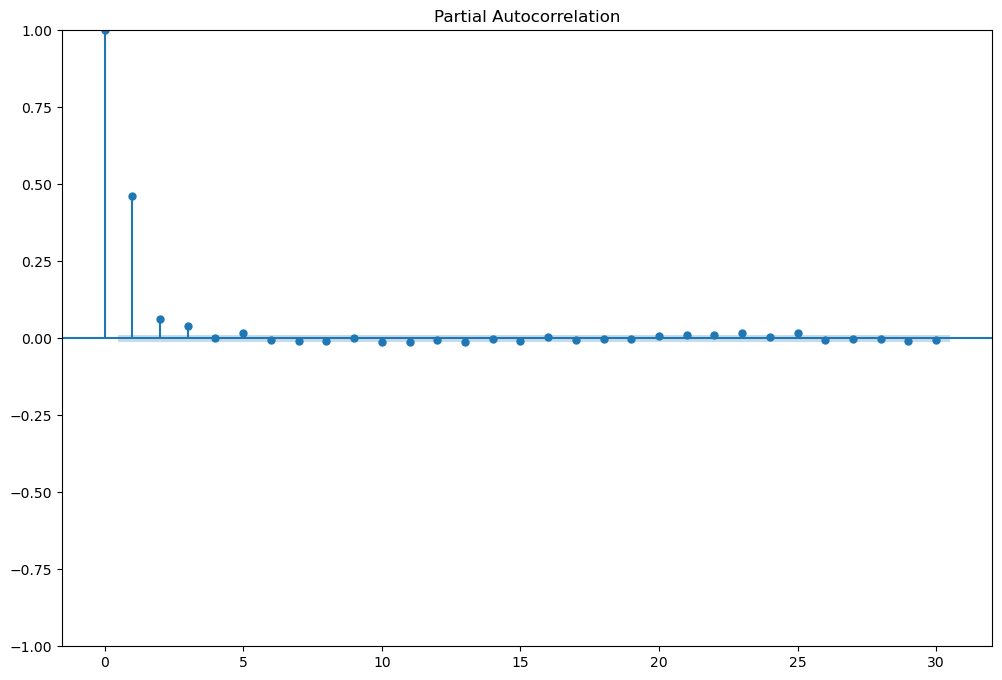

Sub_metering_3


<Figure size 600x400 with 0 Axes>

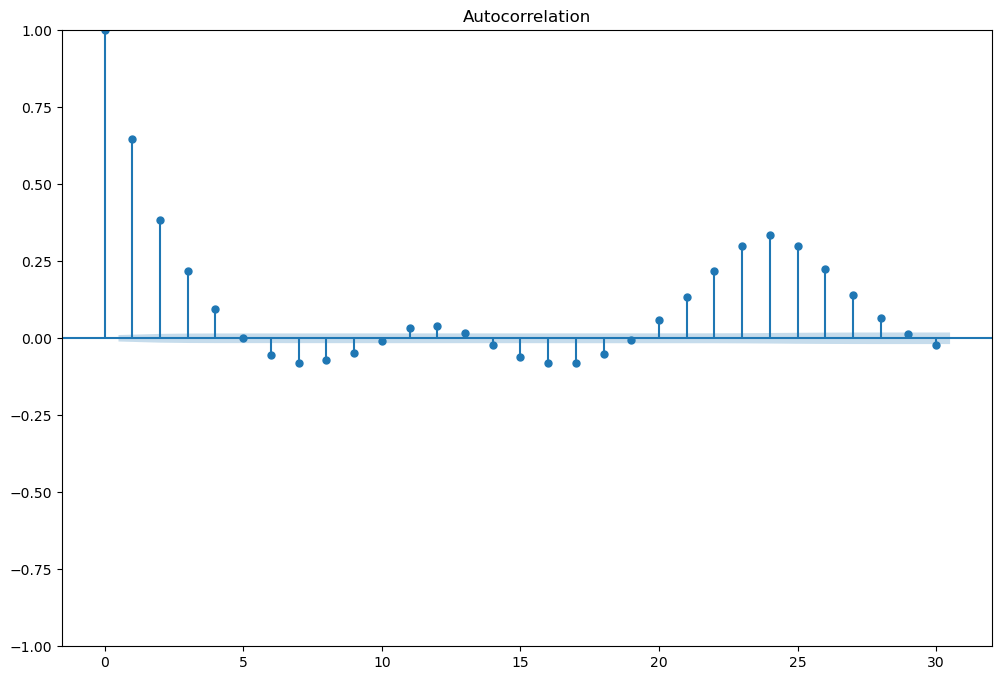

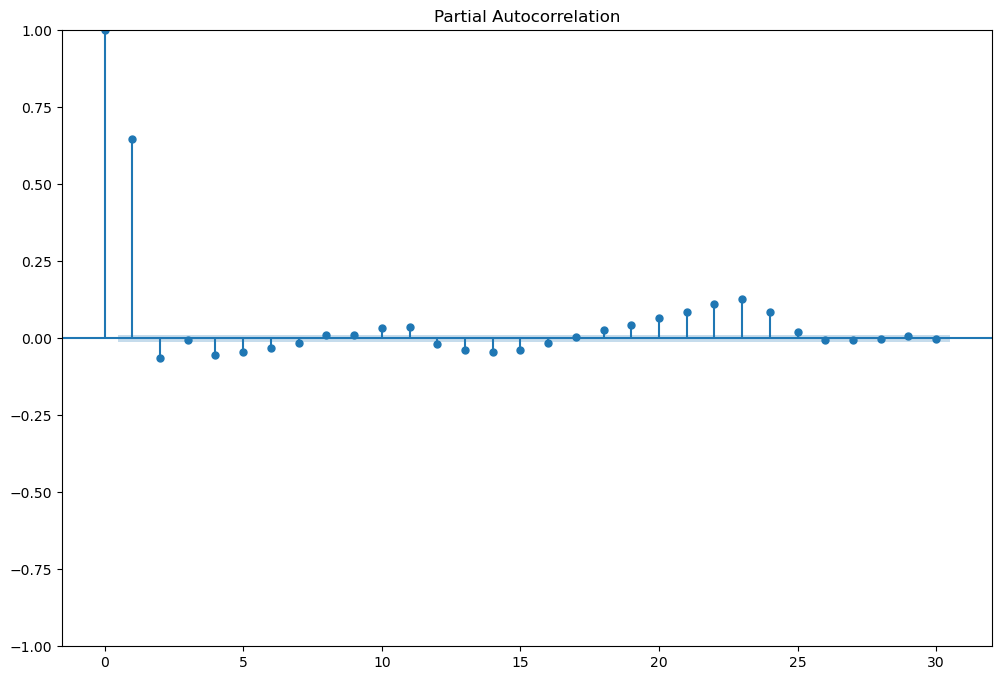

rem_consumption


<Figure size 600x400 with 0 Axes>

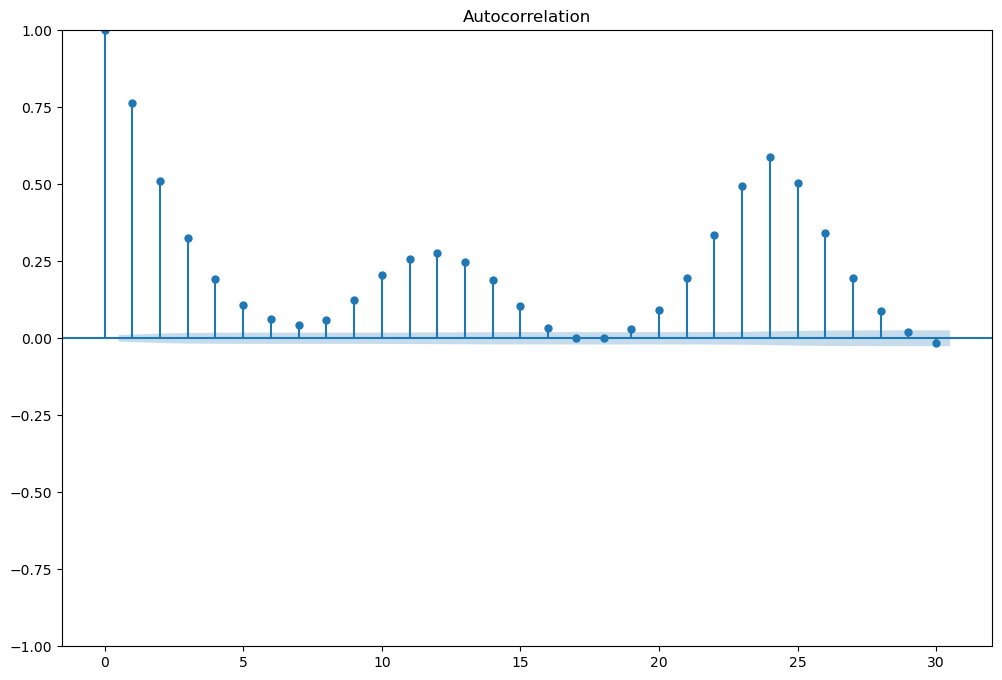

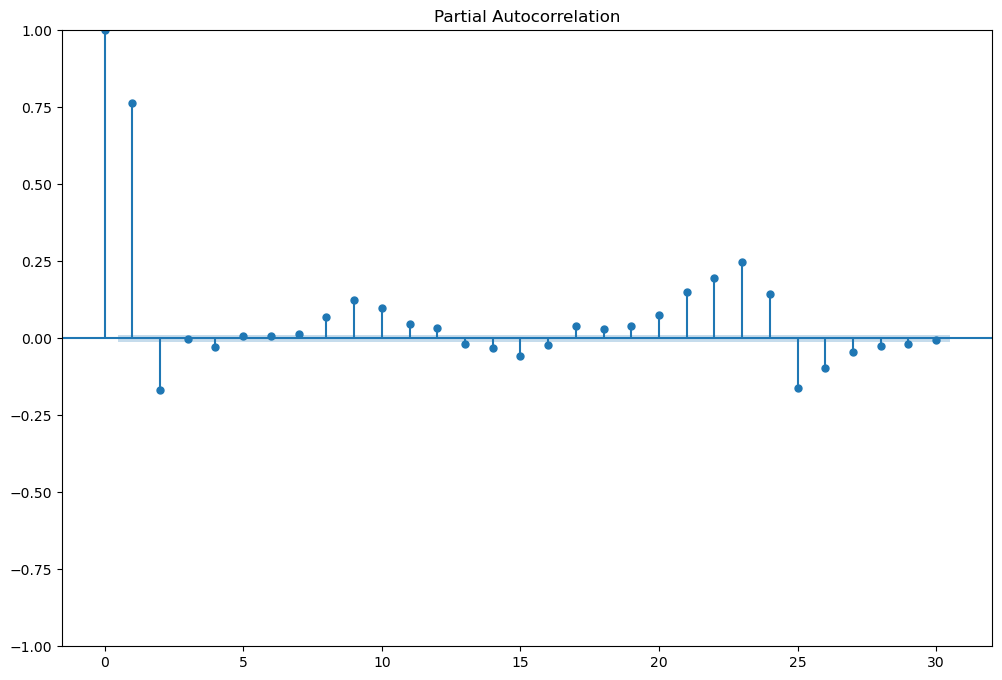

In [18]:
def acf_pacf_plot(time_series):
    plt.figure(figsize=(6, 4))
    plot_acf(time_series, lags=30)
    plt.show();
    plot_pacf(time_series, lags=30)
    plt.show();
for col in hourly_data.columns:
    print(col)
    acf_pacf_plot(hourly_data[col])

Remarks: All columns are autocorrelated. 
Global_active_power - lag 1     
Global_reactive_power - lag 0   
Voltage - lag 1                  
Global_intensity - lag 1         
Sub_metering_1 - lag 0 or lag 1           
Sub_metering_2 - lag 0           
Sub_metering_3 - lag 1
rem_consumption - lag 1

NOTE: It's always better to manually try out and see which lag gives the best results as inferring directly from the plots might be difficult and the inferences might not be reliable

# Multi output model strategy

When dealing with time series data, or any data for that matter, it's crucial to drop unecessary features in order to get accurate results. In this dataset, we want to make future predictions for all the columns and each column requires a different set of columns to get the right results. Hence, we need multiple models to work with this dataset.

We will keep the exogenous features for all the time series columns. These help identify trends and seasonality. 

For Global active power - we will drop Global reactive power, global intensity

For Global reactive power - we will drop Global active power, global intensity

For Voltage - we will drop Global reactive power, global intensity, global active power

For Global intensity - we will drop Global reactive power, global active power

For Sub metering 1 - we will drop Global reactive power, global intensity, global active power, and all the other sub meter measurements

Same for Sub meterings 2, 3 and the remaining consumption as well.

# Feature Engineering
While working with time series data, adding exogenous columns might help our model understand the datetime component associated with it. Extracting the hour, day, month, year, etc components and passing them as new columns is one way and another way is to pass them as sine and cosine waves.

In [19]:
hourly_data['hour'] = hourly_data.index.hour
hourly_data['day'] = hourly_data.index.day
hourly_data['month'] = hourly_data.index.month

In [20]:
def create_cyclical_features(df, column, max_val):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    return df

hourly_data = create_cyclical_features(hourly_data, 'hour', 24)
hourly_data = create_cyclical_features(hourly_data, 'day', 31)
hourly_data = create_cyclical_features(hourly_data, 'month', 12)

In [21]:
hourly_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption,hour,day,month,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
Datetime,,,,,,,,,,,,,,,,,
2006-12-16 17:00:00,3.471100,0.229000,234.643889,14.676667,0.0,0.527778,16.861111,34.904444,17,16,12,-0.965926,-2.588190e-01,-0.101168,-0.994869,-2.449294e-16,1.000000
2006-12-16 18:00:00,3.471100,0.080033,234.580167,14.676667,0.0,6.716667,16.866667,34.904444,18,16,12,-1.000000,-1.836970e-16,-0.101168,-0.994869,-2.449294e-16,1.000000
2006-12-16 19:00:00,3.400233,0.085233,233.796333,14.503333,0.0,1.433333,16.683333,34.904444,19,16,12,-0.965926,2.588190e-01,-0.101168,-0.994869,-2.449294e-16,1.000000
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,34.904444,20,16,12,-0.866025,5.000000e-01,-0.101168,-0.994869,-2.449294e-16,1.000000
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,33.307778,21,16,12,-0.707107,7.071068e-01,-0.101168,-0.994869,-2.449294e-16,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667,15.898333,17,26,11,-0.965926,-2.588190e-01,-0.848644,0.528964,-5.000000e-01,0.866025
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000,26.224444,18,26,11,-1.000000,-1.836970e-16,-0.848644,0.528964,-5.000000e-01,0.866025
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000,27.588889,19,26,11,-0.965926,2.588190e-01,-0.848644,0.528964,-5.000000e-01,0.866025


In [22]:
# We no longer need the direct hour, day and month columns so we drop them
hourly_data = hourly_data.drop(['hour', 'day', 'month'], axis=1)

In [23]:
hourly_data

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
Datetime,,,,,,,,,,,,,,
2006-12-16 17:00:00,3.471100,0.229000,234.643889,14.676667,0.0,0.527778,16.861111,34.904444,-0.965926,-2.588190e-01,-0.101168,-0.994869,-2.449294e-16,1.000000
2006-12-16 18:00:00,3.471100,0.080033,234.580167,14.676667,0.0,6.716667,16.866667,34.904444,-1.000000,-1.836970e-16,-0.101168,-0.994869,-2.449294e-16,1.000000
2006-12-16 19:00:00,3.400233,0.085233,233.796333,14.503333,0.0,1.433333,16.683333,34.904444,-0.965926,2.588190e-01,-0.101168,-0.994869,-2.449294e-16,1.000000
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,34.904444,-0.866025,5.000000e-01,-0.101168,-0.994869,-2.449294e-16,1.000000
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,33.307778,-0.707107,7.071068e-01,-0.101168,-0.994869,-2.449294e-16,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667,15.898333,-0.965926,-2.588190e-01,-0.848644,0.528964,-5.000000e-01,0.866025
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000,26.224444,-1.000000,-1.836970e-16,-0.848644,0.528964,-5.000000e-01,0.866025
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000,27.588889,-0.965926,2.588190e-01,-0.848644,0.528964,-5.000000e-01,0.866025


# Model training

In [24]:
# Converting the columns into a format that works with an LSTM
def df_to_x_y(df, window_size=24):
    x = []
    y = []
    for i in range(len(df) - window_size):
        row = [a for a in df[i : i + window_size]]
        x.append(row)
        label = df[i + window_size][0]
        y.append(label)
    return np.array(x), np.array(y)

# defining another function for the entire preprocessing of the input data
def preprocess(df):
    # Train, val, test split
    n = len(df)
    train_size = int(n * 0.7)
    val_size = int(n * 0.15)
    test_size = n - train_size - val_size

    train_end = train_size
    val_end = train_size + val_size

    train_data = df.iloc[:train_end]
    val_data = df.iloc[train_end:val_end]
    test_data = df.iloc[val_end:]

    # we convert it into float to avoid rounding off errors that we face with int during normalization
    train_data = train_data[train_data.columns].astype(float)
    val_data = val_data[val_data.columns].astype(float)
    test_data = test_data[test_data.columns].astype(float)

    #LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
    scaler = StandardScaler()
    scaler = scaler.fit(train_data)
    train_data_scaled = scaler.transform(train_data)
    val_data_scaled = scaler.transform(val_data)
    test_data_scaled = scaler.transform(test_data)
    X_train, y_train = df_to_x_y(train_data_scaled)
    X_val, y_val = df_to_x_y(val_data_scaled)
    X_test, y_test = df_to_x_y(test_data_scaled)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler

# defining another function for training
def train(input_x, input_y):
    model = Sequential()
    model.add(InputLayer((input_x, input_y)))
    model.add(LSTM(64))
    model.add(Dropout(rate=0.2))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    return model

# defining anothe function for evaluation
def test(X_test, y_test_true, num_cols, scaler, model):
    y_test_pred = model.predict(X_test)
    # in order to perform inverse scaler transform we need to have the exact same number of columns as during fitting the scaler
    df1 = pd.DataFrame(y_test_pred)
    df2 = pd.DataFrame(y_test_true)
    if num_cols == 12:
        dummy_df_pred = df1[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
        dummy_df_true = df2[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    elif num_cols == 11:
        dummy_df_pred = df1[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
        dummy_df_true = df2[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
    else:
        dummy_df_pred = df1[[0, 0, 0, 0, 0, 0, 0]]
        dummy_df_true = df2[[0, 0, 0, 0, 0, 0, 0]]
    df1 = pd.concat([df1, dummy_df_pred], axis=1)
    df2 = pd.concat([df2, dummy_df_true], axis=1)
    
    df_test_forecast = scaler.inverse_transform(df1)
    df_test_true = scaler.inverse_transform(df2)
    df_test_forecast = pd.DataFrame(df_test_forecast)
    df_test_true = pd.DataFrame(df_test_true)
    
    plt.plot(df_test_true[0])
    plt.plot(df_test_forecast[0])
    
    mse = math.sqrt(mean_squared_error(df_test_true[0], df_test_forecast[0]))
    print(f"mse: {mse}")
    return mse

## Global active power

Epoch 1/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.5186 - val_loss: 0.3437
Epoch 2/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3614 - val_loss: 0.3277
Epoch 3/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3415 - val_loss: 0.3273
Epoch 4/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3324 - val_loss: 0.3229
Epoch 5/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3242 - val_loss: 0.3199
Epoch 6/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3175 - val_loss: 0.3182
Epoch 7/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3140 - val_loss: 0.3134
Epoch 8/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3057 - val_loss: 0.3176
Epoch 9/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3019 - val_loss: 0.3172
Epoch 10/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2989 - val_loss: 0.3183
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mse: 0.44932577023103115


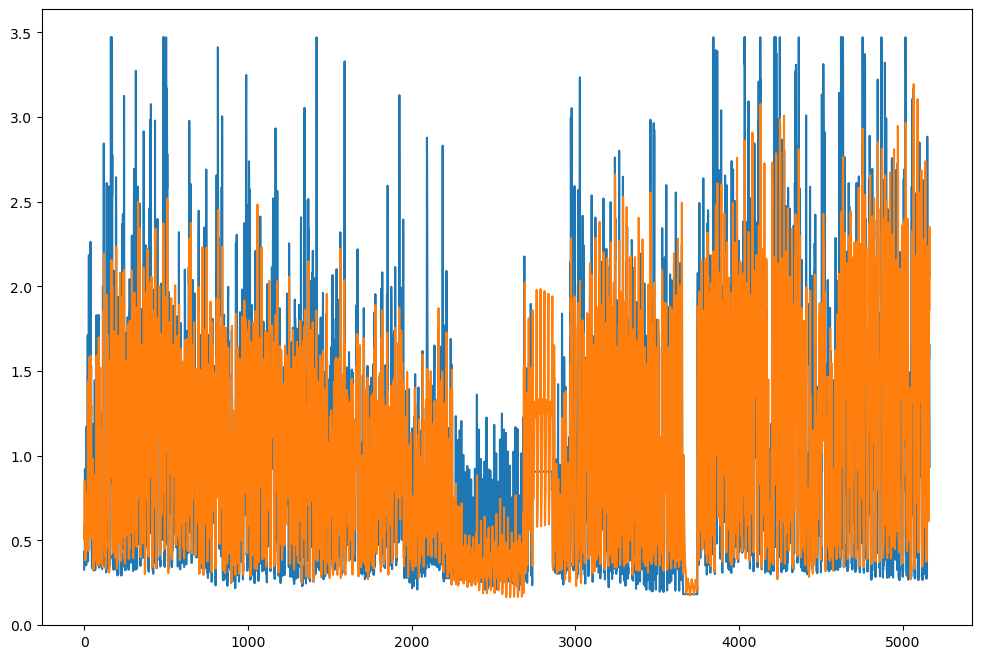

In [25]:
drop_cols = ['Global_reactive_power', 'Global_intensity']
df = hourly_data.drop(drop_cols, axis=1)
X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess(df)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
model_gap = train(24, 12)
mse_gap = test(X_test, y_test, 12, scaler, model_gap)

## Global reactive power

Epoch 1/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7170 - val_loss: 0.8167
Epoch 2/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6217 - val_loss: 0.8156
Epoch 3/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6029 - val_loss: 0.7964
Epoch 4/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5782 - val_loss: 0.7946
Epoch 5/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5600 - val_loss: 0.8017
Epoch 6/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5457 - val_loss: 0.7933
Epoch 7/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5344 - val_loss: 0.8034
Epoch 8/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5248 - val_loss: 0.7982
Epoch 9/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5169 - val_loss: 0.8099
Epoch 10/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5093 - val_loss: 0.8149
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mse: 0.05065616746345551


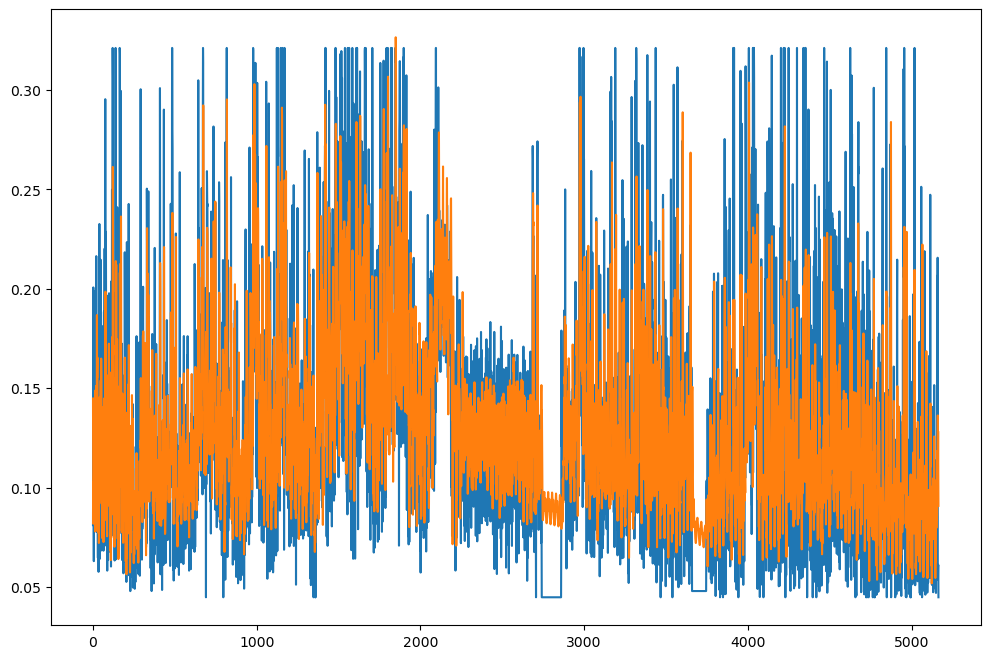

In [28]:
drop_cols = ['Global_active_power', 'Global_intensity']
df = hourly_data.drop(drop_cols, axis=1)
X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess(df)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
model_grp = train(24, 12)
mse_grp = test(X_test, y_test, 12, scaler, model_grp)

## Voltage

Epoch 1/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4334 - val_loss: 0.2768
Epoch 2/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2406 - val_loss: 0.2631
Epoch 3/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2247 - val_loss: 0.2528
Epoch 4/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2151 - val_loss: 0.2497
Epoch 5/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2076 - val_loss: 0.2539
Epoch 6/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2025 - val_loss: 0.2485
Epoch 7/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1965 - val_loss: 0.2482
Epoch 8/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1908 - val_loss: 0.2393
Epoch 9/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1865 - val_loss: 0.2390
Epoch 10/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1835 - val_loss: 0.2367
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mse: 1.2496337509250166


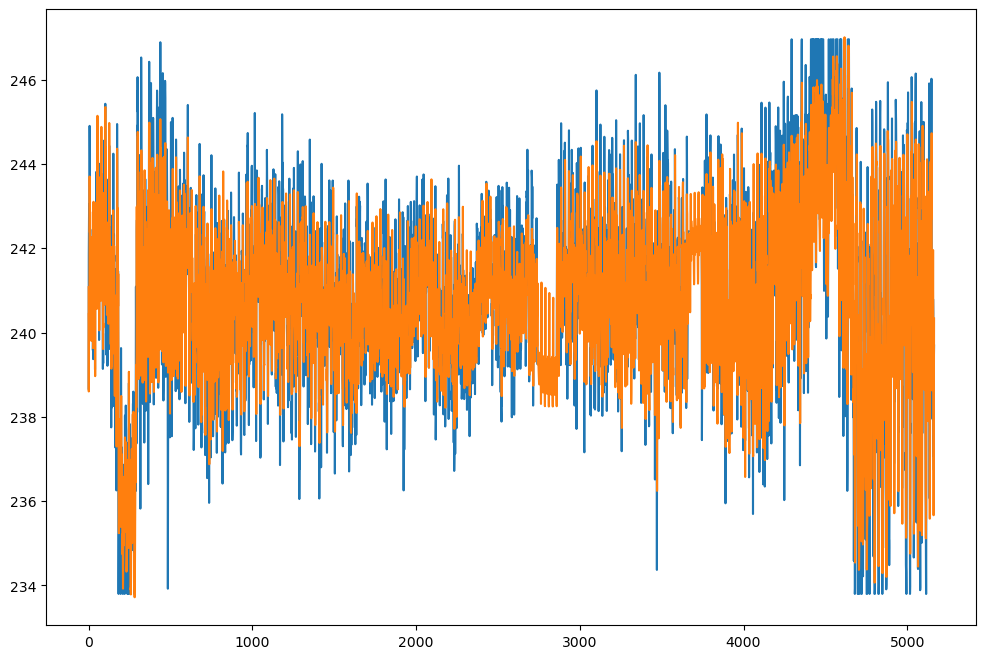

In [29]:
drop_cols = ['Global_active_power', 'Global_intensity', 'Global_reactive_power']
df = hourly_data.drop(drop_cols, axis=1)
X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess(df)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
model_v = train(24, 11)
mse_v = test(X_test, y_test, 11, scaler, model_v)

In [30]:
hourly_data['Voltage_temp'] = hourly_data['Voltage']
hourly_data = hourly_data.drop('Voltage', axis=1)

In [31]:
hourly_data.head()

,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,Voltage_temp
Datetime,,,,,,,,,,,,,,
2006-12-16 17:00:00,3.471100,0.229000,14.676667,0.0,0.527778,16.861111,34.904444,-0.965926,-2.588190e-01,-0.101168,-0.994869,-2.449294e-16,1.0,234.643889
2006-12-16 18:00:00,3.471100,0.080033,14.676667,0.0,6.716667,16.866667,34.904444,-1.000000,-1.836970e-16,-0.101168,-0.994869,-2.449294e-16,1.0,234.580167
2006-12-16 19:00:00,3.400233,0.085233,14.503333,0.0,1.433333,16.683333,34.904444,-0.965926,2.588190e-01,-0.101168,-0.994869,-2.449294e-16,1.0,233.796333
2006-12-16 20:00:00,3.268567,0.075100,13.916667,0.0,0.000000,16.783333,34.904444,-0.866025,5.000000e-01,-0.101168,-0.994869,-2.449294e-16,1.0,234.071500
2006-12-16 21:00:00,3.056467,0.076667,13.046667,0.0,0.416667,17.216667,33.307778,-0.707107,7.071068e-01,-0.101168,-0.994869,-2.449294e-16,1.0,237.158667


## Global intensity

Epoch 1/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5460 - val_loss: 0.3473
Epoch 2/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3652 - val_loss: 0.3347
Epoch 3/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3466 - val_loss: 0.3226
Epoch 4/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3374 - val_loss: 0.3194
Epoch 5/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3295 - val_loss: 0.3152
Epoch 6/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3191 - val_loss: 0.3145
Epoch 7/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3150 - val_loss: 0.3185
Epoch 8/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3106 - val_loss: 0.3179
Epoch 9/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.3052 - val_loss: 0.3170
Epoch 10/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3014 - val_loss: 0.3162
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mse: 1.8750511958571254


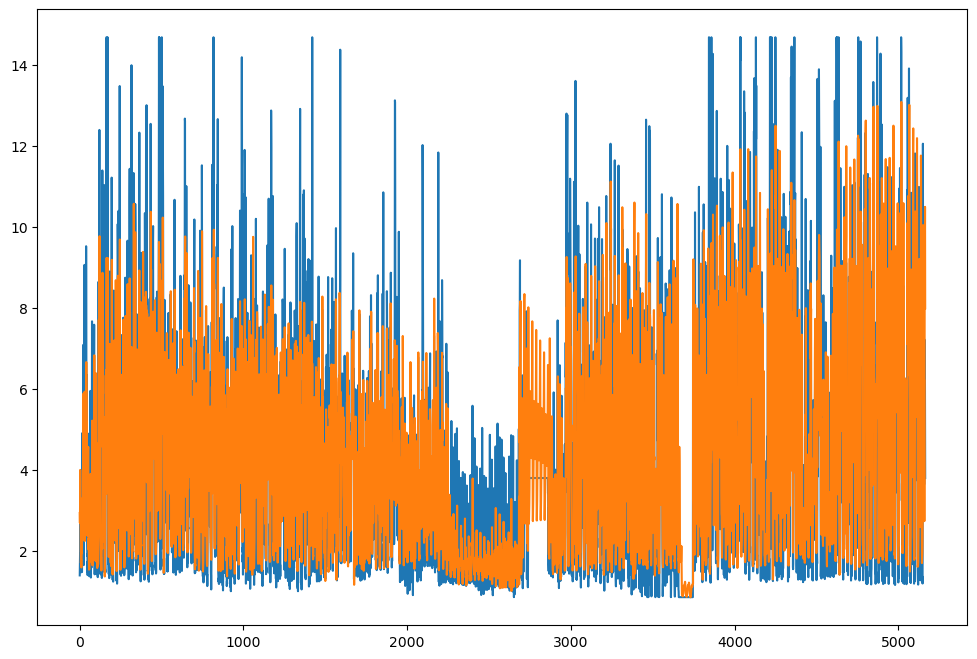

In [32]:
drop_cols = ['Global_active_power', 'Global_reactive_power']
df = hourly_data.drop(drop_cols, axis=1)
X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess(df)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
model_gi = train(24, 12)
mse_gi = test(X_test, y_test, 12, scaler, model_gi)

## Sub metering 1

Epoch 1/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.8668 - val_loss: 0.7567
Epoch 2/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7386 - val_loss: 0.7392
Epoch 3/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7175 - val_loss: 0.7252
Epoch 4/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6951 - val_loss: 0.7078
Epoch 5/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6788 - val_loss: 0.7008
Epoch 6/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6718 - val_loss: 0.6947
Epoch 7/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6544 - val_loss: 0.6834
Epoch 8/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6495 - val_loss: 0.6814
Epoch 9/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6362 - val_loss: 0.6735
Epoch 10/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6322 - val_loss: 0.6694
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mse: 2.0451769916324567


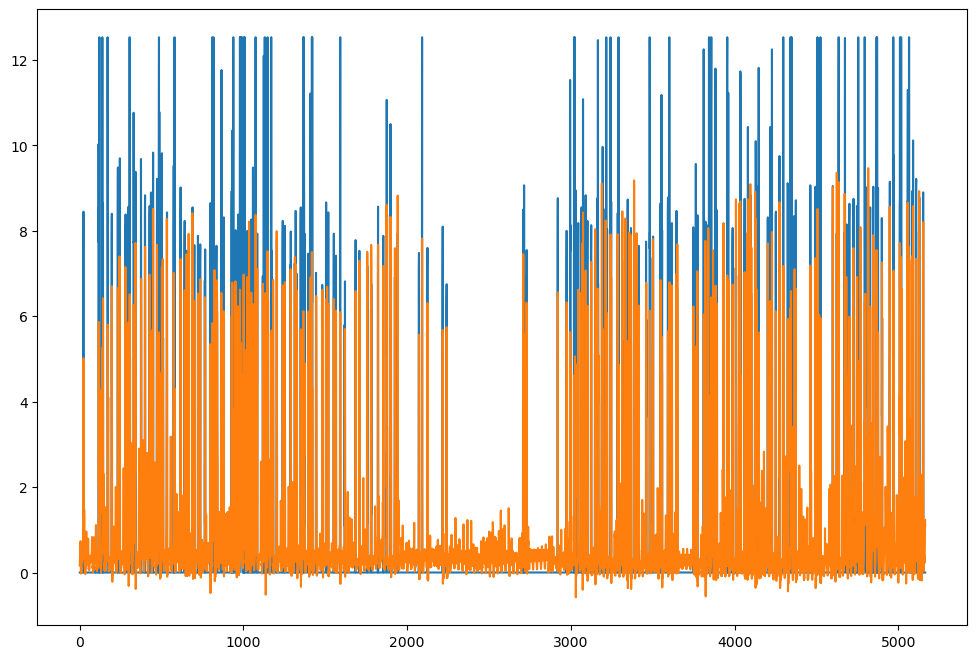

In [34]:
drop_cols = ['Global_active_power', 'Global_intensity', 'Global_reactive_power', 'Sub_metering_2',
            'Sub_metering_3', 'rem_consumption']
df = hourly_data.drop(drop_cols, axis=1)
X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess(df)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
model_s1 = train(24, 8)
mse_s1 = test(X_test, y_test, 8, scaler, model_s1)

## Sub metering 2

Epoch 1/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8387 - val_loss: 0.6593
Epoch 2/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.7343 - val_loss: 0.6452
Epoch 3/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7195 - val_loss: 0.6477
Epoch 4/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7051 - val_loss: 0.6478
Epoch 5/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6930 - val_loss: 0.6499
Epoch 6/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6882 - val_loss: 0.6612
Epoch 7/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6800 - val_loss: 0.6686
Epoch 8/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6754 - val_loss: 0.6737
Epoch 9/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6649 - val_loss: 0.6700
Epoch 10/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6620 - val_loss: 0.6821
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mse: 2.247463158153746


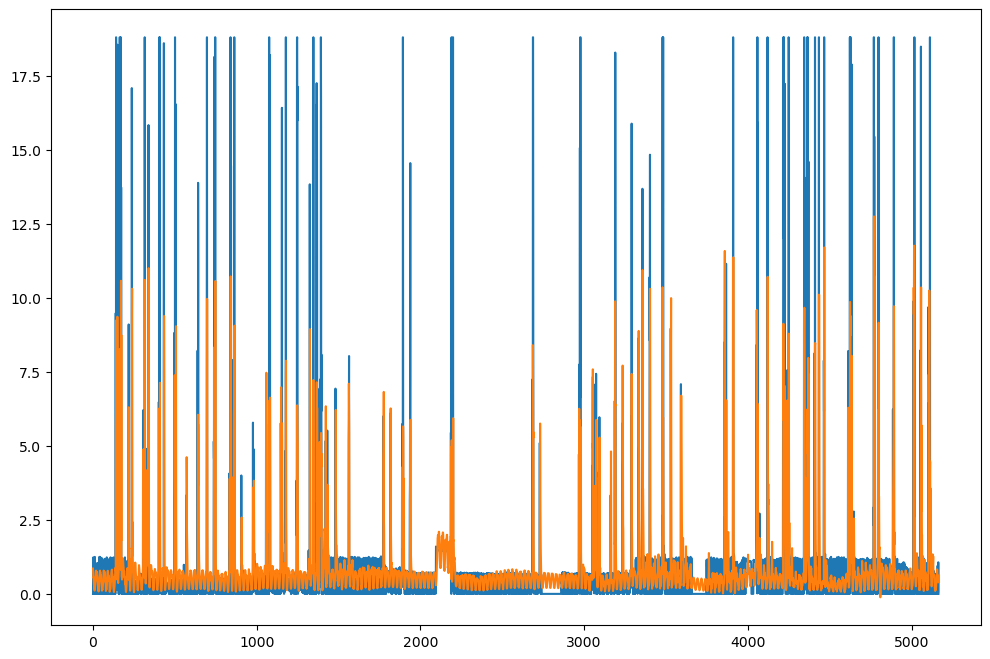

In [36]:
drop_cols = ['Global_active_power', 'Global_intensity', 'Global_reactive_power', 'Sub_metering_1',
            'Sub_metering_3', 'rem_consumption']
df = hourly_data.drop(drop_cols, axis=1)
X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess(df)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
model_s2 = train(24, 8)
mse_s2 = test(X_test, y_test, 8, scaler, model_s2)

## Sub metering 3

Epoch 1/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6723 - val_loss: 0.5397
Epoch 2/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4947 - val_loss: 0.5251
Epoch 3/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.4775 - val_loss: 0.4846
Epoch 4/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4603 - val_loss: 0.4819
Epoch 5/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.4504 - val_loss: 0.4648
Epoch 6/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.4450 - val_loss: 0.4703
Epoch 7/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4318 - val_loss: 0.4605
Epoch 8/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4235 - val_loss: 0.4394
Epoch 9/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4152 - val_loss: 0.4442
Epoch 10/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4094 - val_loss: 0.4393
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mse: 4.725562228742693


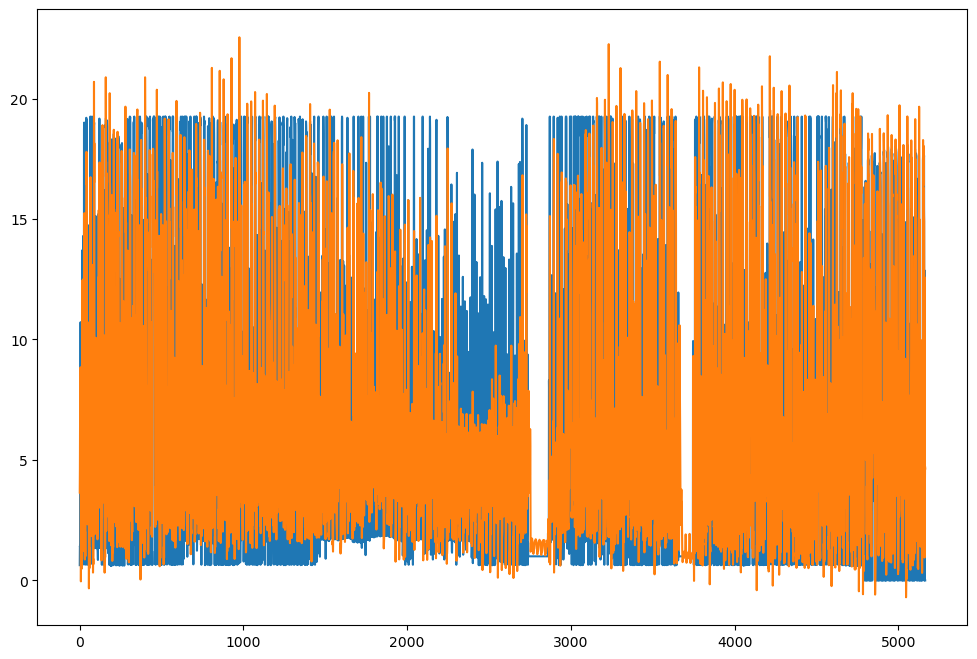

In [38]:
drop_cols = ['Global_active_power', 'Global_intensity', 'Global_reactive_power', 'Sub_metering_1',
            'Sub_metering_2', 'rem_consumption']
df = hourly_data.drop(drop_cols, axis=1)
X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess(df)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
model_s3 = train(24, 8)
mse_s3 = test(X_test, y_test, 8, scaler, model_s3)

## Remaining consumption

Epoch 1/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4758 - val_loss: 0.2743
Epoch 2/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2964 - val_loss: 0.2452
Epoch 3/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2696 - val_loss: 0.2367
Epoch 4/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2593 - val_loss: 0.2366
Epoch 5/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2535 - val_loss: 0.2372
Epoch 6/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2478 - val_loss: 0.2347
Epoch 7/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2435 - val_loss: 0.2362
Epoch 8/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2408 - val_loss: 0.2362
Epoch 9/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2391 - val_loss: 0.2395
Epoch 10/10
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2342 - val_loss: 0.2396
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
mse: 3.2489318947509482


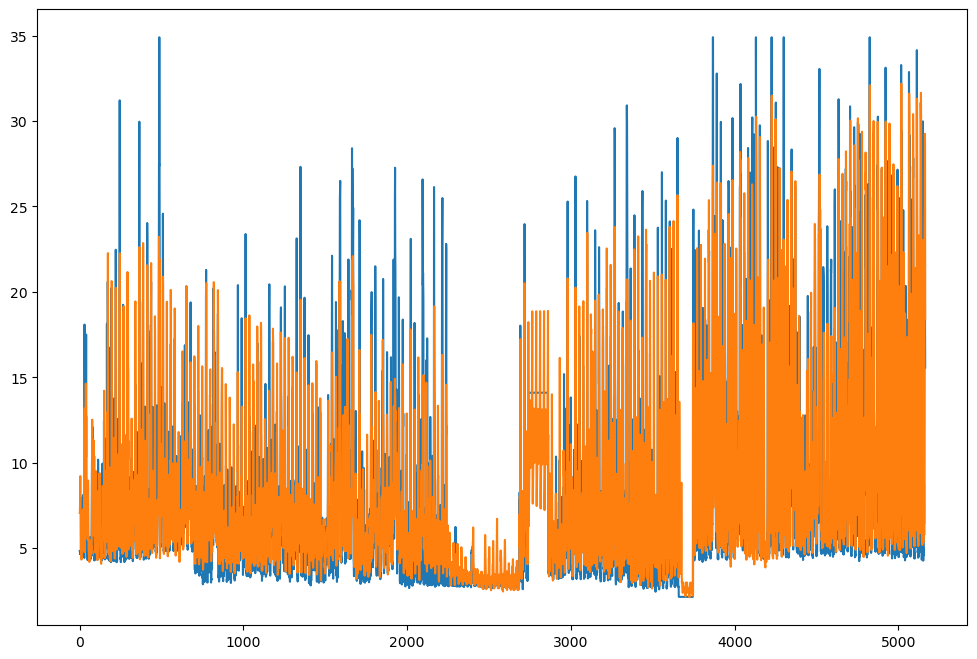

In [39]:
drop_cols = ['Global_active_power', 'Global_intensity', 'Global_reactive_power', 'Sub_metering_1',
            'Sub_metering_3', 'Sub_metering_2']
df = hourly_data.drop(drop_cols, axis=1)
X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess(df)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
model_rem = train(24, 8)
mse_rem = test(X_test, y_test, 8, scaler, model_rem)

# Saving the models

In [41]:
joblib.dump(model_gap, 'model_gap.joblib')
joblib.dump(model_grp, 'model_grp.joblib')
joblib.dump(model_v, 'model_v.joblib')
joblib.dump(model_gi, 'model_gi.joblib')
joblib.dump(model_s1, 'model_s1.joblib')
joblib.dump(model_s2, 'model_s2.joblib')
joblib.dump(model_s3, 'model_s3.joblib')
joblib.dump(model_rem, 'model_rem.joblib')

['model_rem.joblib']